# Anomaly Detection On IP Address Data - A Simple Practical Example using Isolation Forest and SHAP.

In this notebook, we are going to 

    1. Extract source IP addresses from network traffic data of millions of packets.
    2. Four-octets Feature extraction from IP addresses and apply PCA to reduce dimensions to help clusters visualization. 
    3. Use Isolation Forest to identify anamolous IP addresses present in the source addresses.
    4. Visualize the clusters of IP addresses along with the anomalies detected.
    5. Use (SHAP) SHapley Additive exPlanations tool to explain/interpret the output of the anomaly detection model.
  

##### Import libraries

In [3]:
# Basic data analysis packages
import datetime
import pandas as pd
import numpy as np

# Sklearn isolation forest and SHAP for interpreting the model
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
import shap

# Visualization tools
import matplotlib as plt
import matplotlib.pyplot as pyplot
import seaborn as sns

## 1. Load IP packets data and extract the Source IP addresses from the data

### Read the packets csv file
The pcaps.csv file contains nearly 6 million rows of IP network data.
##### I am not able to upload this huge file to github. So please do not run this code when you try.
Instead I have uploaded the extracted src IP data as **src_ip_addr.csv** which you can use for modelling in the next few steps seen shortly. 


In [6]:
df_file = "pcaps.csv"

df = pd.read_csv(df_file, parse_dates=["timestamp"], \
                 dtype=object, index_col=["timestamp"])

print(sorted(df.columns))
print(df.shape)

['Unnamed: 0', 'arpdst', 'arpop', 'arppdst', 'arppsrc', 'arpsrc', 'bootpchaddr', 'bootpciaddr', 'bootpgiaddr', 'bootpop', 'bootpsiaddr', 'bootpyiaddr', 'dhcpoptions', 'dnsopcode', 'edst', 'esrc', 'etype', 'icmpcode', 'icmptype', 'id', 'idst', 'iperrordst', 'iperrorproto', 'iperrorsrc', 'iplen', 'iproto', 'ipttl', 'isrc', 'len', 'ntpmode', 'tdport', 'tsport', 'twindow', 'uerrordst', 'uerrorsrc', 'ulen', 'utdport', 'utsport', 'vlan']
(5998837, 39)


In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Extract source and destination IP addresses from the network traffic data

The data has details of each network packet as a row in the data frame. 

In [9]:
df.head(10)

,Unnamed: 0,id,len,esrc,edst,etype,vlan,isrc,idst,iproto,...,bootpgiaddr,bootpchaddr,dhcpoptions,ntpmode,arpop,arpsrc,arpdst,arppsrc,arppdst,dnsopcode
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-03-16 18:00:00,0,0,117,00:16:47:9d:f2:c2,00:0c:29:41:4b:e7,33024,120,192.168.229.254,192.168.202.79,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,1,1,269,00:0c:29:41:4b:e7,00:16:47:9d:f2:c2,33024,120,192.168.202.79,192.168.229.254,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,2,2,70,00:0c:29:41:4b:e7,00:16:47:9d:f2:c2,33024,120,192.168.202.79,192.168.229.251,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,3,3,70,00:16:47:9d:f2:c2,00:0c:29:41:4b:e7,33024,120,192.168.229.254,192.168.202.79,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,4,4,78,00:0c:29:41:4b:e7,00:16:47:9d:f2:c2,33024,120,192.168.202.79,192.168.229.251,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,5,5,217,00:0c:29:41:4b:e7,00:16:47:9d:f2:c2,33024,120,192.168.202.79,192.168.229.153,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,6,6,70,00:16:47:9d:f2:c2,00:0c:29:41:4b:e7,33024,120,192.168.229.251,192.168.202.79,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,7,7,178,00:16:47:9d:f2:c2,00:0c:29:41:4b:e7,33024,120,192.168.229.254,192.168.202.79,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,8,8,82,00:16:47:9d:f2:c2,00:0c:29:41:4b:e7,33024,120,192.168.229.251,192.168.202.79,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5998837 entries, 2012-03-16 18:00:00 to 2012-03-16 18:49:57.250000
Data columns (total 39 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Unnamed: 0    object
 1   id            object
 2   len           object
 3   esrc          object
 4   edst          object
 5   etype         object
 6   vlan          object
 7   isrc          object
 8   idst          object
 9   iproto        object
 10  iplen         object
 11  ipttl         object
 12  tsport        object
 13  tdport        object
 14  twindow       object
 15  utsport       object
 16  utdport       object
 17  ulen          object
 18  icmptype      object
 19  icmpcode      object
 20  iperrorsrc    object
 21  iperrordst    object
 22  iperrorproto  object
 23  uerrorsrc     object
 24  uerrordst     object
 25  bootpop       object
 26  bootpciaddr   object
 27  bootpyiaddr   object
 28  bootpsiaddr   object
 29  bootpgiaddr   object
 30  bootpchadd

In [11]:
print(len(df['isrc'].unique()))
print(len(df['idst'].unique()))

188
2674


There are 188 and 2674 unique source and destination IP addresses in the data set. <br>
Let us extract source addresses as a separate data frame for analysis.

In [13]:
src_ip_df = df['isrc'].copy()
print(src_ip_df)

src_ip_df = src_ip_df.reset_index()
print()
print(src_ip_df)

del src_ip_df['timestamp']
print()
print(src_ip_df.shape)
src_ip_df.head(5)

# Drop missing items from the data frame
src_ip_df = src_ip_df.dropna().copy()
# Drop duplicates
src_ip_df=src_ip_df.drop_duplicates(['isrc'])

src_ip_df = src_ip_df.reset_index()
src_ip_df=src_ip_df.drop(['index'], axis = 1)

print("\nFinal Src IP dataframe extracted:\n")
print(src_ip_df)

#src_ip_df.to_csv("src_ip_addr.csv")

timestamp
2012-03-16 18:00:00.000    192.168.229.254
2012-03-16 18:00:00.000     192.168.202.79
2012-03-16 18:00:00.000     192.168.202.79
2012-03-16 18:00:00.000    192.168.229.254
2012-03-16 18:00:00.000     192.168.202.79
                                ...       
2012-03-16 18:49:57.250    192.168.202.110
2012-03-16 18:49:57.250     192.168.27.253
2012-03-16 18:49:57.250     192.168.27.253
2012-03-16 18:49:57.250     192.168.27.253
2012-03-16 18:49:57.250    192.168.202.110
Name: isrc, Length: 5998837, dtype: object

                      timestamp             isrc
0       2012-03-16 18:00:00.000  192.168.229.254
1       2012-03-16 18:00:00.000   192.168.202.79
2       2012-03-16 18:00:00.000   192.168.202.79
3       2012-03-16 18:00:00.000  192.168.229.254
4       2012-03-16 18:00:00.000   192.168.202.79
...                         ...              ...
5998832 2012-03-16 18:49:57.250  192.168.202.110
5998833 2012-03-16 18:49:57.250   192.168.27.253
5998834 2012-03-16 18:49:57.250 

## 2. Feature extraction from IP addresses

We will use the four octets of IP address as features for clustering and anomaly detection.

In [15]:
src_ip_df = pd.read_csv("src_ip_addr.csv")
src_ip_df

,Unnamed: 0,isrc
0,0,192.168.229.254
1,1,192.168.202.79
2,2,192.168.229.251
3,3,192.168.229.153
4,4,192.168.215.1
...,...,...
182,182,192.168.202.69
183,183,192.168.202.10
184,184,192.168.25.254
185,185,192.168.202.116


In [16]:
src_ip_df=src_ip_df.drop(['Unnamed: 0'], axis = 1)

src_ip_df.loc[:, 'oct1'] = src_ip_df['isrc'].apply(lambda x: x.split(".")[0])
src_ip_df.loc[:, 'oct2'] = src_ip_df['isrc'].apply(lambda x: x.split(".")[1])
src_ip_df.loc[:, 'oct3'] = src_ip_df['isrc'].apply(lambda x: x.split(".")[2])
src_ip_df.loc[:, 'oct4'] = src_ip_df['isrc'].apply(lambda x: x.split(".")[3])

In [17]:
#src_ip_df = src_ip_df.reset_index()
src_ip_df.head(5)

,isrc,oct1,oct2,oct3,oct4
0,192.168.229.254,192,168,229,254
1,192.168.202.79,192,168,202,79
2,192.168.229.251,192,168,229,251
3,192.168.229.153,192,168,229,153
4,192.168.215.1,192,168,215,1


## 3.  Apply PCA to reduce the dimensions and do cluster visualization

In [19]:
X_matrix_src = np.array(src_ip_df[['oct1', 'oct2', 'oct3', 'oct4']])
print(X_matrix_src.shape)
print(X_matrix_src[0:5])
print()

(187, 4)
[['192' '168' '229' '254']
 ['192' '168' '202' '79']
 ['192' '168' '229' '251']
 ['192' '168' '229' '153']
 ['192' '168' '215' '1']]



In [20]:
from sklearn.decomposition import PCA

pcas = PCA(n_components=4)
pcas.fit(X_matrix_src)
print(pcas.explained_variance_ratio_)

[0.70015121 0.27151222 0.02561776 0.00271881]


We see above that 2 principal components are enough for both src and dest data to explain at least 85% variance. Let's proceed with PCA with 2 components.

In [22]:
pca_src = PCA(n_components=2)
pcas = pca_src.fit_transform(X_matrix_src)

pcas1=[]
pcas2=[]

for i in pcas:
    pcas1.append(i[0])
    pcas2.append(i[1])

print(len(pcas1))
print(len(pcas2))

187
187


In [23]:
print(pcas.shape)

(187, 2)


In [24]:
src_ip_df['pca1'] = pcas1
src_ip_df['pca2'] = pcas2
print(src_ip_df[:2])
print()

              isrc oct1 oct2 oct3 oct4    pca1    pca2
0  192.168.229.254  192  168  229  254  -4.762 187.744
1   192.168.202.79  192  168  202   79 -91.854  33.929



##### Scatter plot of Source IP address data

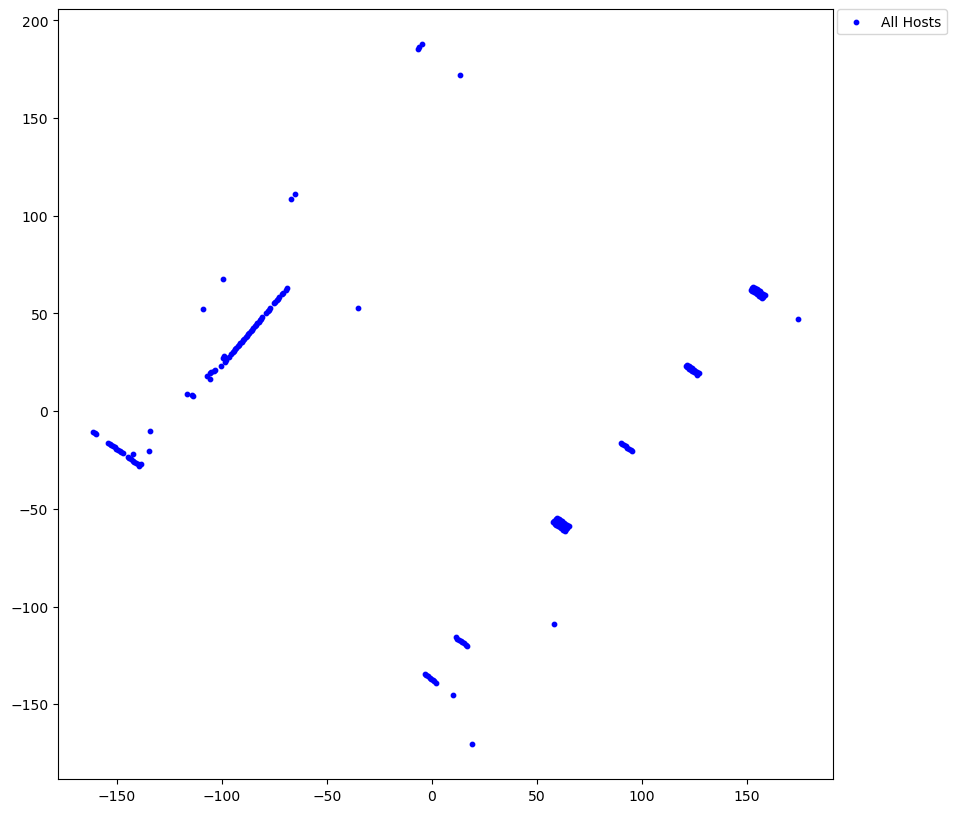

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(src_ip_df['pca1'], src_ip_df['pca2'], s=10, color='blue',label="All Hosts")
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.show()

Visually, it seems like 6 or 7 small clusters are there. Broadly there are two big clusters with ellipsoidal shape and similar orientation. <br>
##### We can see around 10 IP addresses isolated far from the main clusters. These could be outliers/anomalies !


## 4. Anomaly Detection using Isolation Forest

#### Data Preparation for Isolation Forest

In [30]:
src_ip_df

,isrc,oct1,oct2,oct3,oct4,pca1,pca2
0,192.168.229.254,192,168,229,254,-4.762,187.744
1,192.168.202.79,192,168,202,79,-91.854,33.929
2,192.168.229.251,192,168,229,251,-6.618,185.393
3,192.168.229.153,192,168,229,153,-67.267,108.585
4,192.168.215.1,192,168,215,1,-150.336,-19.183
...,...,...,...,...,...,...,...
182,192.168.202.69,192,168,202,69,-98.043,26.092
183,192.168.202.10,192,168,202,10,-134.555,-20.150
184,192.168.25.254,192,168,25,254,155.476,61.886
185,192.168.202.116,192,168,202,116,-68.956,62.928


In [31]:
# Drop all columns except the four octets for Isolation Forest
#src_ip_df2 = src_ip_df.drop(['index', 'isrc', 'pca1', 'pca2'], axis = 1)
src_ip_df2 = src_ip_df.drop(['isrc', 'pca1', 'pca2'], axis = 1)
src_ip_df2

,oct1,oct2,oct3,oct4
0,192,168,229,254
1,192,168,202,79
2,192,168,229,251
3,192,168,229,153
4,192,168,215,1
...,...,...,...,...
182,192,168,202,69
183,192,168,202,10
184,192,168,25,254
185,192,168,202,116


In [32]:
src_ip_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   oct1    187 non-null    object
 1   oct2    187 non-null    object
 2   oct3    187 non-null    object
 3   oct4    187 non-null    object
dtypes: object(4)
memory usage: 6.0+ KB


In [33]:
src_ip_df2 = src_ip_df2.astype(int)
src_ip_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   oct1    187 non-null    int32
 1   oct2    187 non-null    int32
 2   oct3    187 non-null    int32
 3   oct4    187 non-null    int32
dtypes: int32(4)
memory usage: 3.0 KB


In [34]:
src_ip_df2.describe()

,oct1,oct2,oct3,oct4
count,187.000,187.000,187.000,187.000
mean,190.866,166.305,108.872,109.203
std,14.109,16.377,91.909,82.846
min,0.000,0.000,0.000,0.000
25%,192.000,168.000,24.000,57.000
50%,192.000,168.000,28.000,100.000
75%,192.000,168.000,202.000,152.500
max,192.000,168.000,229.000,254.000


#### From the distribution seen above for the four octets, it looks like oct1 and oct2 are almost fixed at 192 and 168 respectively, while oct3 and oct4 have some variance. 

#### Fit Isolation Forest

In [37]:
# CONTAMINATION param seems to be important for Isolation Forest
#contam = 'auto'
#contam = 0.1

# Let us set contamination as 5% as we suspect there could be around 10 anomalies in around 187 IP addresses.
contam = 0.05
model = IsolationForest(random_state=42, max_features = 0.8, contamination = contam)
#model = IsolationForest(random_state=42, n_estimators =50, max_features = 0.8, contamination = contam)

# Predict anomalies by fitting isolation forest model on the given data.
y_pred = model.fit_predict(src_ip_df2, y = None)

In [38]:
# The data which are detected as anomalies are given result as -1, while others are 1.
print(y_pred.shape)
print()
y_pred

(187,)



array([-1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])

In [39]:
# Isolation forest gives a score to each data point. 
# Data points with a negative score <0 are labeled as anomalies (-1). 
# But according to how much negative the score is, we can determine how severe the data point is anamolous.

y_score = model.decision_function(src_ip_df2)
print(y_score)
print()
pd.Series(y_score).describe()

[-0.01025799  0.18590679 -0.04460187 -0.00440757  0.10557076  0.1939783
  0.08093901  0.12336083  0.19771086  0.13783469  0.18512618  0.14474403
  0.04759491  0.09992236  0.15524372  0.09476761  0.15371399  0.09049629
  0.10498108  0.15450276  0.0869849   0.10055007  0.08831655  0.03738238
  0.1020929   0.04107058  0.07225967  0.12539026  0.12357499  0.10223478
  0.10144228  0.18572159  0.10392922  0.12165954  0.09765577  0.09124963
  0.08258392  0.16848738  0.19444705  0.18898038  0.09022622  0.13494561
  0.06595557  0.11632465  0.1863193  -0.00398913 -0.06697442 -0.01700399
  0.18598013  0.18479101  0.17605156  0.18500241  0.18319635  0.10601298
  0.09520468  0.04179435  0.00930796  0.05585138  0.10536837  0.18515216
  0.01766223  0.18846451  0.10014295  0.18655955  0.10181056  0.16349276
  0.13805374  0.16021608  0.12182969  0.07865685  0.18741157  0.16189941
  0.1883063   0.18290622  0.1263875   0.18648599  0.01785096 -0.21556989
 -0.091075   -0.2519104   0.13384474  0.06752769  0.

count   187.000
mean      0.114
std       0.064
min      -0.252
25%       0.091
50%       0.111
75%       0.158
max       0.198
dtype: float64

In [40]:
len(y_score[y_score < 0])

10

In [41]:
# Out of all the IP addresses, the model has detected 10 ip addresses as anomalies.
pd.Series(y_pred).value_counts()

 1    177
-1     10
Name: count, dtype: int64

In [42]:
# What are the indices of the anomalies ?
y_pred_ano = pd.Series(y_pred)[y_pred == -1]
y_pred_ano.index

Index([0, 2, 3, 45, 46, 47, 77, 78, 79, 186], dtype='int64')

In [43]:
#pd.Series(y_score)[y_score < -0.2]

In [44]:
src_ip_df

,isrc,oct1,oct2,oct3,oct4,pca1,pca2
0,192.168.229.254,192,168,229,254,-4.762,187.744
1,192.168.202.79,192,168,202,79,-91.854,33.929
2,192.168.229.251,192,168,229,251,-6.618,185.393
3,192.168.229.153,192,168,229,153,-67.267,108.585
4,192.168.215.1,192,168,215,1,-150.336,-19.183
...,...,...,...,...,...,...,...
182,192.168.202.69,192,168,202,69,-98.043,26.092
183,192.168.202.10,192,168,202,10,-134.555,-20.150
184,192.168.25.254,192,168,25,254,155.476,61.886
185,192.168.202.116,192,168,202,116,-68.956,62.928


In [45]:
# What are the ip addresses detected as anomalies ?
src_ip_df.iloc[y_pred_ano.index]['isrc']

0      192.168.229.254
2      192.168.229.251
3      192.168.229.153
45     192.168.205.253
46       192.168.1.254
47     192.168.229.156
77         172.19.2.66
78     192.168.169.129
79             0.0.0.0
186       192.168.11.1
Name: isrc, dtype: object

## 5. Visualization of anomalies

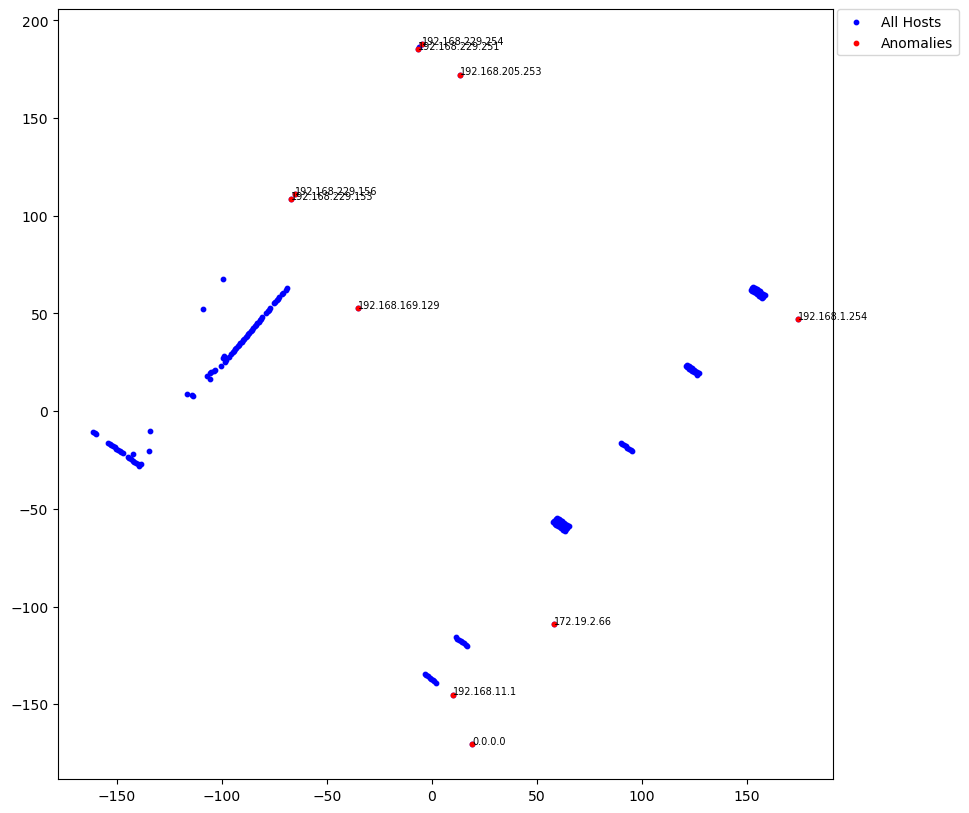

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

ano_src_df = src_ip_df.iloc[y_pred_ano.index]

plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(src_ip_df['pca1'], src_ip_df['pca2'], s=10, color='blue',label="All Hosts")
plt.scatter(ano_src_df['pca1'], ano_src_df['pca2'], s=10, color='red',label="Anomalies")

# Annotating each point with the 'isrc' column values
for i, label in enumerate(ano_src_df['isrc']):
    plt.annotate(label, (ano_src_df['pca1'].iloc[i], ano_src_df['pca2'].iloc[i]), fontsize=7, alpha=1)

plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.show()

##### We can see the 10 ip addresses isolated far from the main clusters have been successfully detected as outliers/anomalies by the Isolation Forest model !

In [49]:
#src_ip_df.iloc[y_pred_ano.index]['isrc']

## 5. Explaining the model output using SHAP

#### The TreeExplainer in SHAP (SHapley Additive exPlanations) 
is a tool specifically designed to explain the output of tree-based machine learning models, such as decision trees, random forests, and gradient boosting models. It utilizes concepts from cooperative game theory (Shapley values) to allocate the contribution of each feature  to the model’s predictions, ensuring each feature's impact is fairly attributed.

##### Typical Use Cases 
**Feature Importance:** Understand which features are most influential in the model’s predictions. <br>
**Individual Prediction Explanation:** View how each feature contributes to a particular prediction. <br>
**Global Understanding:** Aggregate SHAP values across all samples to see general feature importance and behavior.<br>

##### TreeExplainer is particularly useful when interpreting complex tree models, as it provides both global and local explanations.

In [52]:
# Use SHAP's TreeExplainer and apply it on the isolation forest model.

exp = shap.TreeExplainer(model) #Explainer

#Calculate SHAP values
# TreeExplainer calculates Shapley values for each feature, representing its contribution to the final prediction. 
shap_values = exp.shap_values(src_ip_df2) 

shap.initjs()

In [53]:
print(shap_values.shape)
print()
shap_values

(187, 4)



array([[ 0.02261504,  0.02751679, -2.19301292, -1.25807826],
       [ 0.03142799,  0.03978895,  1.31087548,  0.82636353],
       [ 0.02094631,  0.0257693 , -2.10633122, -2.12650183],
       [ 0.02273837,  0.02910904, -2.08640405, -1.2281084 ],
       [ 0.02760291,  0.03865384, -0.82541283,  0.39123756],
       [ 0.03107114,  0.04000906,  1.14770962,  1.27706963],
       [ 0.03030612,  0.04021554, -0.16801315, -0.97325116],
       [ 0.02807469,  0.0395808 , -0.1697068 ,  0.26484107],
       [ 0.03127142,  0.04030952,  1.12647982,  1.43274508],
       [ 0.02925226,  0.04045435,  0.3794954 ,  0.16086524],
       [ 0.03135379,  0.03975848,  1.30132098,  0.8085405 ],
       [ 0.03263434,  0.04463634, -0.28769282,  1.03919879],
       [ 0.0261657 ,  0.03688827, -2.07911094,  0.04729562],
       [ 0.0278386 ,  0.03623881,  0.10015362, -0.6964915 ],
       [ 0.02968284,  0.04107439,  1.163007  , -0.06588451],
       [ 0.02905998,  0.03873754, -0.09572516, -0.65263178],
       [ 0.03318721,  0.

The above output show SHAP values for each ip address for each of the four octets in it.

If a SHAP value for a feature is positive, it suggests that the feature is pushing the model's prediction upwards.
For a binary classification model, a positive SHAP value might be pushing the prediction towards the positive class.

If a SHAP value for a feature is negative, it suggests that the feature is pushing the model's prediction downwards.
In classification, it may push the prediction towards the negative class.

So for example, for a IP address with SHAP values \[ 0.02261504,  0.02751679, -2.19301292, -1.25807826\],
the interpretation should be like the first two octets oct1 and oct2 tend to push the model's prediction towards positive class (not anomaly) and the remaining octets oct3 and oct4 tend to push the model towards the negative side (anomaly). 

    

A **summary_plot** in SHAP is a visualization that combines feature importance and feature effect direction, offering a concise summary of how each feature contributes to the predictions across the dataset. It helps quickly identify the most influential features and understand how their values affect predictions.

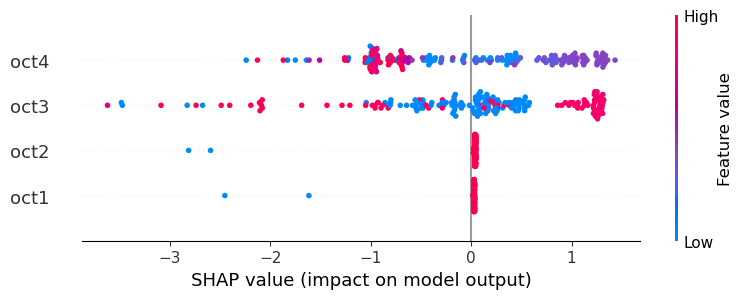

In [56]:
shap.summary_plot(shap_values, src_ip_df2)

#### Key Aspects of the Summary Plot

Each point in the plot corresponds to a specific feature value (SHAP value) for a particular data instance (IP address in our case). 

**Feature Importance:** Features are ranked by importance on the y-axis, with the most influential features appearing at the top.

In our case, oct3 seems to be the most influential feature globally across the entire dataset, in determining the anomalies, followed by oct4, Oct2 and oct1.
This observation matches with what we observed earlier in this exercise - refer to our earlier comment "From the distribution seen above for the four octets, it looks like oct1 and oct2 are almost fixed at 192 and 168 respectively, while oct3 and oct4 have some variance. " <br>


**SHAP Values:** The x-axis shows the SHAP value magnitude, representing the strength of a feature’s impact on model predictions.
In a summary_plot, the SHAP values (x-axis) represent this impact direction. Points to the right of zero indicate a positive impact on the prediction (not anomaly), while points to the left of zero indicate a negative impact (anomaly). The magnitude of the SHAP value shows how strongly the feature influences the prediction in that direction.


**Color Coding:** Each point in the plot corresponds to a specific feature value for a particular instance. Colors (often from blue to red) indicate feature value from low to high, showing how feature values are distributed across different SHAP values.

 For each feature, color variation (blue to red) shows how low or high values affect the outcome. For example, high feature values might push predictions up, and low values might push them down. 
 
In our case, we can see that for oct1 and oct2, the higher values of these features (in red) appear to push the predictions in positive direction (not anomaly) **while just two data points (IP addresses) for each of these two features (oct1 and oct2) appear to be anomalies (in the negative direction).**

##### Let's take a closer  look at the shap values and summary_plot for only the ten anomaly IP addresses detected.

In [59]:
# Shap values for the anomalous IP addresses.
for i in list(zip(src_ip_df.iloc[y_pred_ano.index]['isrc'], shap_values[y_pred_ano.index])):
    print(i)

('192.168.229.254', array([ 0.02261504,  0.02751679, -2.19301292, -1.25807826]))
('192.168.229.251', array([ 0.02094631,  0.0257693 , -2.10633122, -2.12650183]))
('192.168.229.153', array([ 0.02273837,  0.02910904, -2.08640405, -1.2281084 ]))
('192.168.205.253', array([ 0.02365199,  0.02773101, -1.43483372, -1.86927001]))
('192.168.1.254', array([ 0.0311405 ,  0.02288837, -3.47140509, -1.25730705]))
('192.168.229.156', array([ 0.02234743,  0.02834643, -2.10108843, -1.50833657]))
('172.19.2.66', array([-1.61430419, -2.81147698, -2.82617666, -0.29280162]))
('192.168.169.129', array([ 0.02273717,  0.02647291, -3.61895806, -1.61267291]))
('0.0.0.0', array([-2.45105213, -2.59331524, -2.67247128, -0.44792079]))
('192.168.11.1', array([ 0.03283106,  0.03152633, -3.48101198, -0.474005  ]))


##### From the above output, take a look at the below two IP addresses for example..<br>
('172.19.2.66', array([-1.61430419, -2.81147698, -2.82617666, -0.29280162])) <br>
('0.0.0.0', array([-2.45105213, -2.59331524, -2.67247128, -0.44792079]))

Out of the ten anomaly IP addresses, oct1 and oct2 both are negative values only for these two IP addresses.
These two IP addresses are the two points that we see for oct1 and oct2 on the negative side of the summary plot.

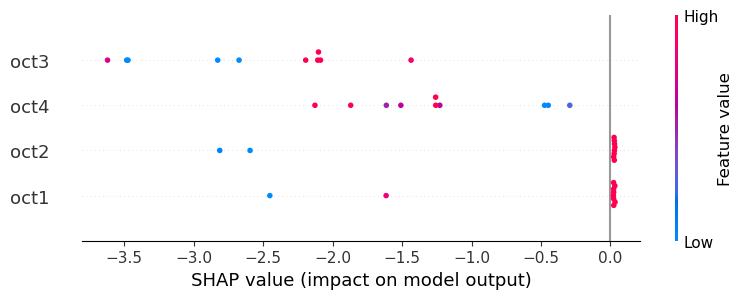

In [61]:
# Shap summary plot for only the anomalies.
shap.summary_plot(shap_values[y_pred_ano.index], src_ip_df2.iloc[y_pred_ano.index])

Taking a closer look at those two IP addresses - 172.19.2.66 and 0.0.0.0, <br>
the first octet oct1 are 172 and 0, respectively. 172 is on the higher side and 0 is the lowest value.
So the first IP address's point in the above summary plot is red in color for oct1. 

In [63]:
#print(src_ip_df2['oct1'].describe())
#ano_src_df['oct1'].value_counts()

In [64]:
#percentiles = np.linspace(0.76, 1, num=25, endpoint=True) #To generate an array of percentiles from 76(0.76) to 100(1.0)
#src_ip_df2.quantile(percentiles)

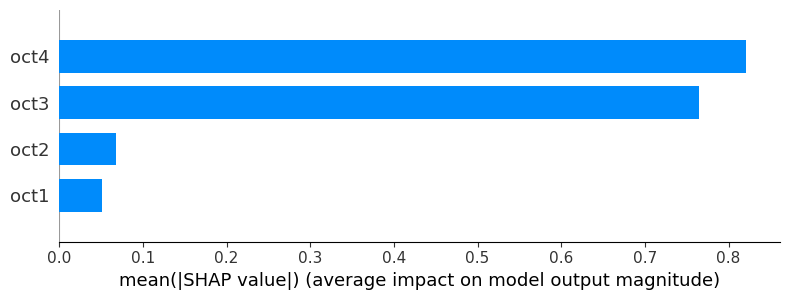

In [65]:
#In SHAP (SHapley Additive exPlanations) summary plots, 
# setting plot_type="bar" generates a bar chart that shows the mean absolute SHAP values for each feature,
# allowing you to easily see the overall importance of each feature in the model.

shap.summary_plot(shap_values, src_ip_df2, plot_type="bar")

In [66]:
ano_src_df

,isrc,oct1,oct2,oct3,oct4,pca1,pca2
0,192.168.229.254,192,168,229,254,-4.762,187.744
2,192.168.229.251,192,168,229,251,-6.618,185.393
3,192.168.229.153,192,168,229,153,-67.267,108.585
45,192.168.205.253,192,168,205,253,13.471,172.154
46,192.168.1.254,192,168,1,254,174.327,47.079
47,192.168.229.156,192,168,229,156,-65.410,110.936
77,172.19.2.66,172,19,2,66,58.107,-108.918
78,192.168.169.129,192,168,169,129,-34.991,52.758
79,0.0.0.0,0,0,0,0,19.352,-170.485
186,192.168.11.1,192,168,11,1,9.901,-145.042


In [67]:
# Shap values for the anomalous IP addresses.
for i in list(zip(src_ip_df.iloc[y_pred_ano.index]['isrc'], shap_values[y_pred_ano.index])):
    print(i)

('192.168.229.254', array([ 0.02261504,  0.02751679, -2.19301292, -1.25807826]))
('192.168.229.251', array([ 0.02094631,  0.0257693 , -2.10633122, -2.12650183]))
('192.168.229.153', array([ 0.02273837,  0.02910904, -2.08640405, -1.2281084 ]))
('192.168.205.253', array([ 0.02365199,  0.02773101, -1.43483372, -1.86927001]))
('192.168.1.254', array([ 0.0311405 ,  0.02288837, -3.47140509, -1.25730705]))
('192.168.229.156', array([ 0.02234743,  0.02834643, -2.10108843, -1.50833657]))
('172.19.2.66', array([-1.61430419, -2.81147698, -2.82617666, -0.29280162]))
('192.168.169.129', array([ 0.02273717,  0.02647291, -3.61895806, -1.61267291]))
('0.0.0.0', array([-2.45105213, -2.59331524, -2.67247128, -0.44792079]))
('192.168.11.1', array([ 0.03283106,  0.03152633, -3.48101198, -0.474005  ]))


#### Plot SHAP values for a single prediction

The force_plot in SHAP visualizations provides a detailed, instance-specific interpretation 
of a model's prediction by showing the individual contributions of each feature value. 
This plot helps understand how each feature influences the model's prediction for a particular instance, 
highlighting the positive and negative impacts that push the prediction up or down from the base value (average prediction). <br>

Let's take two anomaly instances to look at the instance-specific (local) interpretation. <br>

45	 192.168.205.253	<br>
77   172.19.2.66

In [69]:
# 45 192.168.205.253
shap.force_plot(exp.expected_value, shap_values[45],features =src_ip_df2.iloc[45,:] ,feature_names =src_ip_df2.columns)

##### How to Interpret force_plot:
###### Base Value:

This is usually the average predicted value across all instances in the dataset.
In the plot, it’s shown as the starting point.

###### Feature Contributions (SHAP Values):

Each feature’s SHAP value is represented as a horizontal bar.
Positive SHAP values (pushing prediction up) are shown in red, indicating features that increase the prediction from the base value.
Negative SHAP values (pushing prediction down) are shown in blue, indicating features that decrease the prediction from the base value.

A bar plot makes it more clearer 

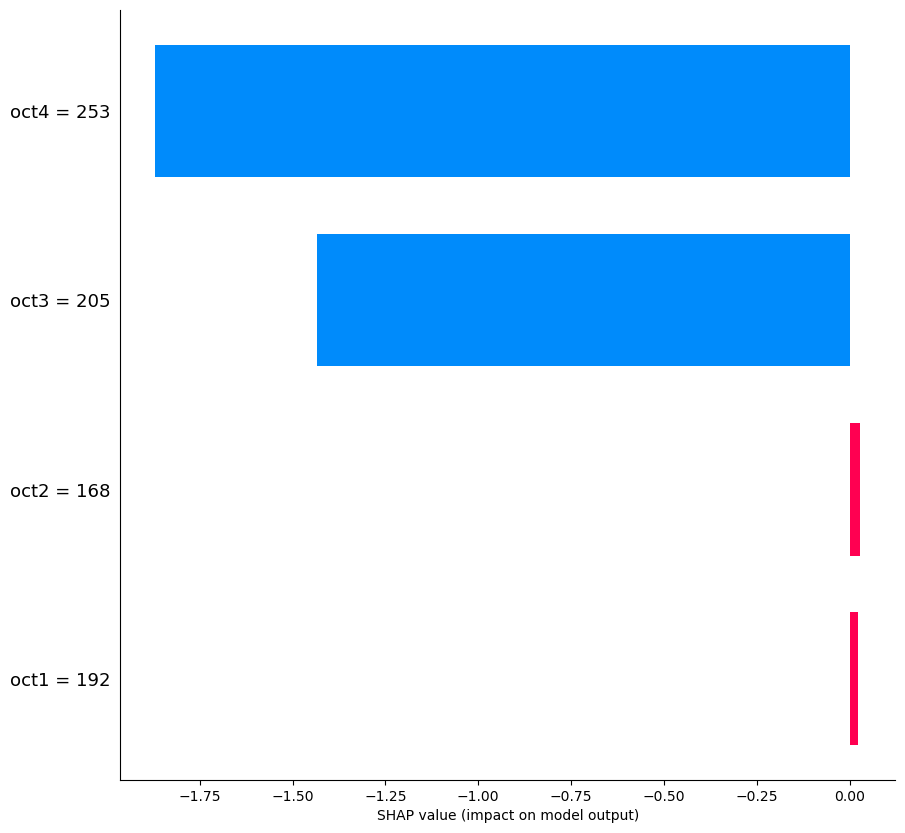

In [71]:
# Bar plot
shap.bar_plot(shap_values[45], features =src_ip_df2.iloc[45,:], feature_names =src_ip_df2.columns )

The above plot shows that for the anomaly IP address 192.168.205.253, the first two octets contribute slightly in positive direction (not anomaly prediction ), but oct3 and oct4 contribute heavily in the negative direction and makes the final prediction as negative (anomaly).

In [73]:
# 77 172.19.2.66
shap.force_plot(exp.expected_value, shap_values[77],features =src_ip_df2.iloc[77,:] ,feature_names =src_ip_df2.columns)

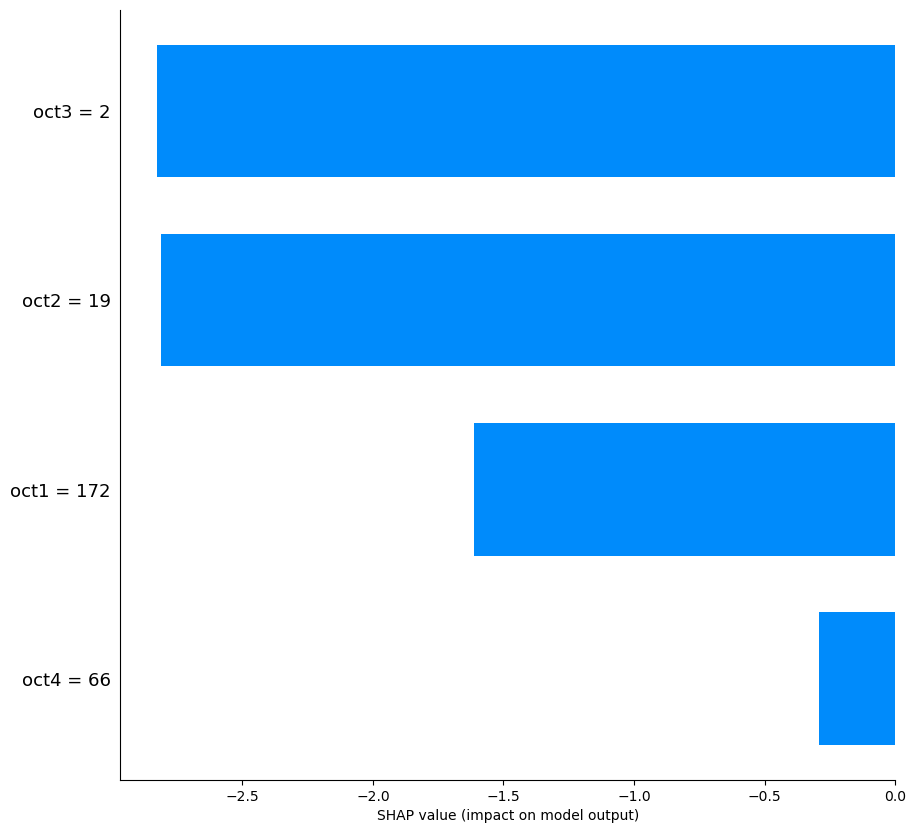

In [74]:
shap.bar_plot(shap_values[77],features =src_ip_df2.iloc[77,:] ,feature_names =src_ip_df2.columns )

The above plot shows that for the anomaly IP address 172.19.2.66, all the octets contribute in the negative direction and makes the final prediction as negative (anomaly), with Octet 2 and 3 making major contributions.